# Comparison between ALOHA and HFSS fields

In this notebook we compare the results from ALOHA and HFSS, the electric field and the spectra


In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c, pi
import h5py # used to read Matlab V7.3 .mat files

## Convenient functions

First, we make a convenient function which will be used to calculate the spectral density power spectrum excited by an antenna from the electric and magnetic fields calculates by HFSS (or something else).

In [2]:
def calculate_spectrum(z, E, H, f=3.7e9):
    """
    Calculate the spectral power density spectrum 
    along the toroidal index (n_parallel) from the E and H fields
    """
    k0 = 2*pi*f/c
    lambda0 = c/f
    
    # fourier domain points
    B = 2**18
    Efft = np.fft.fftshift(np.fft.fft(E, n=B, axis=1))
    Hfft = np.fft.fftshift(np.fft.fft(H, n=B, axis=1))
    
    # fourier domain bins
    dz = z[1] - z[0] # assumes spatial period is constant
    df = 1/(B*dz)
    K = np.arange(-B/2,+B/2)
    # spatial frequency bins
    Fz= K*df
    # parallel index is kz/k0
    nz= (2*pi/k0)*Fz
    
    # ~ power density spectrum
    p = (dz)**2/lambda0 * (1/2*Efft*np.conj(Hfft));
    
    return nz, p

Now we need a routine to import the electromagnetic field exported along a line from HFSS

In [3]:
def import_HFSS_fld(filename):
    #HFSS fld are particularly badly made. They use both space and tab separator, 
    # label NaN as "Nan", etc... Anyway, we can still achieve it:
    data=pd.read_csv(filename, 
                skiprows=2, index_col=False, delim_whitespace=True, na_values='Nan',
               names=['X', 'Y', 'Z', 'AxRe', 'AxIm', 'AyRe', 'AyIm', 'AzRe', 'AzIm']).fillna(0)
    # Create the complex-valued vector components
    data['Ax'] = data.AxRe + 1j*data.AxIm
    data['Ay'] = data.AyRe + 1j*data.AyIm
    data['Az'] = data.AzRe + 1j*data.AzIm
    R = np.array([data.X, data.Y, data.Z])
    A = np.array([data.Ax, data.Ay, data.Az])
    return R, A


We also need a routine to extract the results from ALOHA, saved in matlab format .mat. In order to keep the compatibility with prior version, ALOHA saves its results in Matlab v7.3. To open such files, one needs to use HDF5

In [4]:
def import_ALOHA_spectrum(filename):
    # import only the results data of the ALOHA scenario
    arrays = {}
    f = h5py.File(filename)
    for k, v in f['scenario']['results'].items():
        arrays[k] = np.array(v)

    # awful code. Could we do better?
    _dP_nz = arrays['dP_nz'].squeeze()
    _nz = arrays['nz'].squeeze()

    dP_nz, nz = [], []
    for n, val in enumerate(_nz):
        nz.append(_nz[n])
        dP_nz.append(_dP_nz[n][0] + 1j*_dP_nz[n][1])
    nz = np.array(nz)
    dP_nz = np.array(dP_nz)

    return nz, dP_nz

def import_ALOHA_Ez(filename):
    # import only the results data of the ALOHA scenario
    arrays = {}
    f = h5py.File(filename)
    for k, v in f['scenario']['results'].items():
        arrays[k] = np.array(v)

    # awful code. Could we do better?
    _z = arrays['abs_z'].squeeze()
    _E = arrays['E_mouth'].squeeze()

    z, Ez = [], []
    for n, val in enumerate(_z):
        z.append(_z[n])
        Ez.append(_E[n][2][0] + 1j*_E[n][2][1])
    z = np.array(z)
    Ez = np.array(Ez)

    return z, Ez

## Power density spectrum

In [38]:
# ALOHA spectrum
nz_ALOHA, dP_nz_ALOHA = import_ALOHA_spectrum(
    'results_ALOHA/ALOHA_Ne2Nc_Ln1cm_dgap1mm.mat')

# HFSS fields and spectrum  
R, E_HFSS = import_HFSS_fld('results_HFSS/Ne2Nc_Ln1cm_dgap1mm_Efield.fld')
R, H_HFSS = import_HFSS_fld('results_HFSS/Ne2Nc_Ln1cm_dgap1mm_Hfield.fld')
# z axis direction is inverted btw HFSS and ALOHA :
# left to right as seen from the plasma in ALOHA.
nz_HFSS, dP_nz_HFZZ = calculate_spectrum(-R[2], E_HFSS, H_HFSS)


C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


<IPython.core.display.Javascript object>


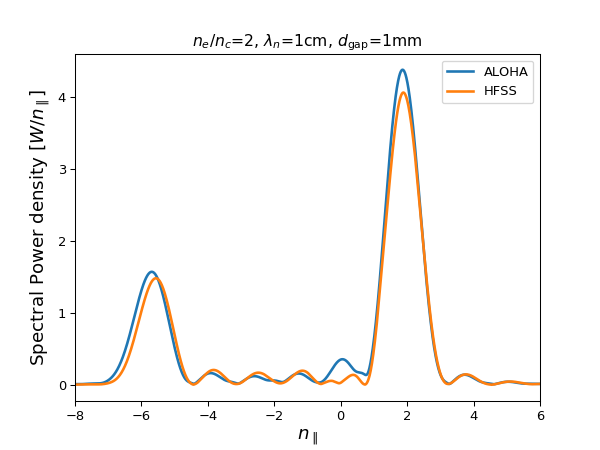

In [40]:
fig, ax = plt.subplots()
# The power density spectrum in HFSS is multiplied by the square root of
# the waveguide height (76mm) in order to match the ALOHA code which is 1D 
# (infinite height waveguide). 
# The proper way would be to generate the 2D spectrum of HFSS from the E,H field in
# antenna mouth plane, then integrate along the poloidal wavenumber dimension. 
# The former approach is equivalent is you assume the field is fourier-transformable 
# in the poloidal direction (1D hypothesis)
ax.plot(nz_ALOHA, np.abs(dP_nz_ALOHA),
        nz_HFSS, np.abs(dP_nz_HFZZ[0])*np.sqrt(76e-3), 
       lw=2)
ax.set_xlim(-8, 6)
ax.set_xlabel('$n_\parallel$', fontsize=14)
ax.set_ylabel('Spectral Power density [$W/n_\parallel$]', fontsize=14)
ax.set_title('$n_e/n_c$=2, $\lambda_n$=1cm, $d_\mathrm{gap}$=1mm')
ax.legend(('ALOHA', 'HFSS'))

fig.savefig('LH_HFSS_vs_ALOHA_spectrum.png', dpi=150)

## Antenna mouth electric field

In [41]:
# Ez field from ALOHA
z_ALOHA, Ez_ALOHA = import_ALOHA_Ez('results_ALOHA/ALOHA_Ne2Nc_Ln1cm_dgap1mm.mat')

<IPython.core.display.Javascript object>


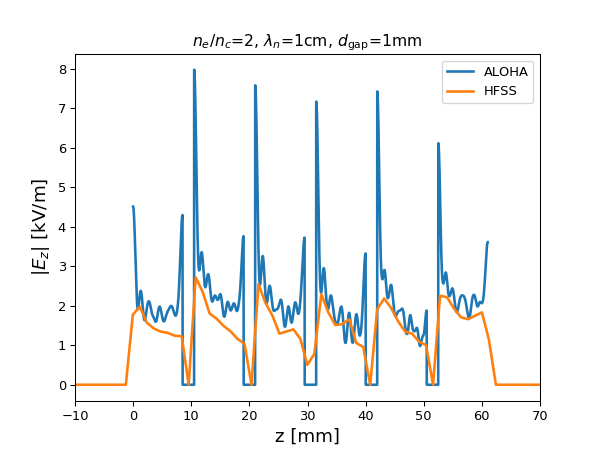

In [42]:
fig, ax = plt.subplots()
# In ALOHA, the z start at the first waveguide, while in HFSS 
# it starts from the opposite side  and this needs to be inverted
ax.plot(z_ALOHA*1e3, np.abs(Ez_ALOHA)/1e3, 
        (0.271-R[2])*1e3, np.abs(E_HFSS[2])/1e3,
       lw=2)
ax.set_xlim(-0.01*1e3, 0.07*1e3)
ax.set_xlabel('z [mm]', fontsize=14)
ax.set_ylabel('|$E_z$| [kV/m]', fontsize=14)
ax.set_title('$n_e/n_c$=2, $\lambda_n$=1cm, $d_\mathrm{gap}$=1mm')
ax.legend(('ALOHA', 'HFSS'))

fig.savefig('LH_HFSS_vs_ALOHA_Ez.png', dpi=150)

## CSS Styling

In [9]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../custom.css", "r").read()
    return HTML(styles)
css_styling()